# Comparison of (sub)KKR and (sub)KBR to an Analytical Baseline

kernel Kalman ruleでは、観測の誤差Rが一定とみなしている。

ただ、計測器が違う観測がある場合、この仮定とは反する。

そこで予測した分散を次の観測誤差に用いる。

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
# enable inline plotting
%matplotlib inline
# uncomment this line to open a console with the same kernel
%qtconsole

import time

import numpy as np
import pandas as pd

import scipy.linalg as linalg
import scipy.spatial as spatial
import scipy.stats as stats

#  RMSE
from sklearn.metrics import mean_squared_error

# heatmap
import seaborn as sns

import matplotlib.pyplot as plt

from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

from kkr import *

Loading BokehJS ...

## Estimation of a Gaussian distribution

In this notebook, we want to show a comparison of the (subspace) kernel Kalman rule ((sub)KKR) and the (subspace) kernel Bayes' rule ((sub)KBR) to an analytical baseline.
The idea of this comparison is the following: we get samples from a Gaussian distribution, but don't know the mean.
In the first part we assume the variance still to be known, later we want to infer the variance as well.

Using a set of training samples, we can embed a prior distribution and learn the operators for (sub)KBR and (sub)KKR.
We can use these then to iteratively infer the mean (and later the variance) of an unknow Gaussian distribution by only observing samples from it.
To compare both inference methods to a baseline, we can also do this analytically by assuming a conjugate prior and white Gaussian noise.


### Drawing samples

The underlying process is the following:
* First, a latent context $c$ is sampled randomly from a uniform distribution in the range $[-5, 5]$.
* Then, around that context, we draw a Gaussian sample with $\mu = c$ and $\sigma = 0.3$. This is the observation.

As training data, we sample $n$ latent contexts $c_i$ and for each context a single sample from the Gaussian distribution $\mathcal N(c_i,\sigma)$ at that location.

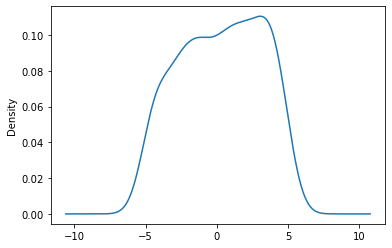

In [3]:
num_samples = 500

data = pd.DataFrame(
    np.zeros((num_samples,2)),
    columns=['context','samples']
)

data['context'] = np.random.uniform(low=-5, high=5, size=(num_samples,1))

noise_mean = 0
noise_std = 1/3
data['samples'] = np.random.normal(loc=data['context'] + noise_mean, scale=noise_std)

# kernel density estimation on the samples
ax = data['samples'].plot.kde()

To compare the methods, we sample a single test context $c^\ast$ from the same uniform distribution and then draw samples $y_i$ from the Gaussian $\mathcal N(c^\ast,\sigma)$ as observations.
From these observations we then want to infer the latent context $c^\ast$ using Bayes' rule.

### Constant variance

In [4]:
test_context = np.random.uniform(low=-5, high=5, size=1)

# draw samples
numTestSamples = 50
plotSteps = 1

print("test_context:", test_context)
test_data = np.append(stats.norm(loc=test_context + noise_mean, scale=1/5).rvs(size=(10)), stats.norm(loc=test_context + noise_mean, scale=1/4).rvs(size=(10)))
test_data = np.append(test_data, stats.norm(loc=test_context + noise_mean, scale=1/3).rvs(size=(10)))
test_data = np.append(test_data, stats.norm(loc=test_context + noise_mean, scale=1/2).rvs(size=(10)))
test_data = np.append(test_data, stats.norm(loc=test_context + noise_mean, scale=1).rvs(size=(10)))

testData = pd.DataFrame(
#     np.random.normal(loc=test_context + noise_mean,
#                      scale=noise_std,
#                      size=(numTestSamples)),
    test_data,
    columns=['samples']
)

# print(testData['samples'])

test_context: [-0.65266679]


### not constant variance

In [56]:
test_context = np.random.uniform(low=-5, high=5, size=1)

groundTruthN = stats.norm(loc=test_context + noise_mean, scale=noise_std)


# draw samples
numTestSamples = 50
plotSteps = 1

testData = pd.DataFrame(
#     np.random.normal(loc=test_context + noise_mean,
#                      scale=noise_std,
#                      size=(numTestSamples)),
    groundTruthN.rvs(size=numTestSamples),
    columns=['samples']
)

# # Ground Truth
# print(test_context + noise_mean)
# testData['samples'][10] = test_context + noise_std * 4
# testData['samples'][40] = test_context - noise_std * 4

# # テストデータに外れ値を入れる
# print(testData['samples'])

### Kernel Kalman Rule

For the kernel Kalman rule, we start again with choosing some hyper-parameters:

In [57]:
kernel_size = 100         # number of data points in the kernel matrices
alphaO = np.exp(-10)      # regularization parameter for the inverses
alphaQ = np.exp(-10)

Select the bandwidth according to the median trick

In [58]:
bandwidths = {'context': 0, 'samples': 0}

for k in ['context', 'samples']:
    distances = spatial.distance.pdist(data[[k]], metric='sqeuclidean')
    bandwidths[k] = np.sqrt(np.median(distances))

bandwidth_factor_k = np.exp(.0)    # bandwidth factor of the kernel function k
bandwidth_factor_g = np.exp(.0)    # bandwidth factor of the kernel function g

bandwidth_k = bandwidth_factor_k * bandwidths['context']
bandwidth_g = bandwidth_factor_g * bandwidths['samples']

Select a random subset of the training data for learning the kernel Kalman rule

In [59]:
reference_set = data[['context', 'samples']].sample(n=kernel_size)#.sort_index()

In [60]:
kernel_k = ExponentialQuadraticKernel()
kernel_k.bandwidth = bandwidth_k
kernel_k.normalized = True

K = kernel_k(reference_set[['context']].values)

kernel_g = ExponentialQuadraticKernel()
kernel_g.bandwidth = bandwidth_g

G = kernel_g(reference_set[['samples']].values)
k_g = lambda y: kernel_g(reference_set[['samples']].values, y)

Compute the conditional operator from the context Hilbert space to the observation Hilbert space

In [61]:
O = linalg.solve(K + alphaO * np.eye(kernel_size), K, assume_a='pos')
X = reference_set[['samples']].values

_r = O - np.eye(kernel_size)
R = (_r.dot(_r.T)) / kernel_size

From the training data we can now embed the prior distribution

In [62]:
K_all = kernel_k(reference_set[['context']].values,
                               data[['context']].values)
C_0 = linalg.solve(K + alphaO * np.eye(kernel_size), K_all, assume_a='pos')

m_0 = np.mean(C_0, axis=1, keepdims=True)
S_0 = np.cov(C_0)

# normalization
S_0 = 0.5 * (S_0 + S_0.T)
[eig_v, eig_r] = linalg.eigh(S_0)
eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
S_0 = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

tuning kernel's bandwidth

With this we can now iteratively apply the kernel Kalman rule to get the posterior estimates of the mean for each time step

In [63]:
# initialize belief states
m = m_0.copy()
S = S_0.copy()

for i in range(numTestSamples):
    # embed observation
    y = testData.loc[i, 'samples'].reshape((-1,1))
    g_y = k_g(y)
    
    # compute kernel Kalman gain
    Q_nominator_T = O.dot(S.T)
    Q_denominator_T = (O.dot(S).dot(O.T) + R).dot(G) + alphaQ * np.eye(kernel_size)
#     Q_denominator_T = O.dot(S).dot(O.T).dot(G) + alphaQ * np.eye(kernel_size)
    Q = linalg.solve(Q_denominator_T, Q_nominator_T, overwrite_a=True, overwrite_b=True).T
    # perform Kalman update
    m = m + Q.dot(g_y - G.dot(O).dot(m))
    S = S - Q.dot(G).dot(O).dot(S)
    
    # normalization
    S = 0.5 * (S + S.T)
    [eig_v, eig_r] = linalg.eigh(S)
    eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
    S = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

    m = m / m.sum(axis=0)
    
    # project into state space
    testData.loc[i,'kkrMu'] = X.T.dot(O.dot(m))[0][0]
    testData.loc[i,'kkrVar'] = X.T.dot(O.dot(S).dot(O.T)).dot(X)[0][0]
#     testData.loc[i,'kkrMAP'] =

print(testData.loc[numTestSamples-1,'kkrMu'])

-0.2616109695161297


### My kernel Kalman rule

In [70]:
# regularization parameter
alpha_a = np.exp(-10)

A = linalg.inv(K + alpha_a * np.eye(kernel_size))
m = linalg.solve(A.dot(G).dot(A).dot(K), A.dot(kernel_g(reference_set[['samples']].values, testData[['samples']].values)), overwrite_a=True, overwrite_b=True)

#normalization
m = m / m.sum(axis=0)

mykkrMu = X.T.dot(A.dot(K).dot(m))
print(mykkrMu)

[[-1.66776919e-01  4.45518237e-01 -1.72215185e-01 -3.53382049e-01
  -5.59455931e-02 -2.82203549e-01 -1.36987825e+00 -2.22874791e-01
  -9.52303769e-02 -4.08665791e-01  2.12998871e-01 -2.64595166e-01
  -3.85507470e-01  3.82163593e-02 -8.61210835e-02 -8.99842352e-01
  -2.53191094e-02 -3.50012592e-01 -5.60332225e-01 -5.51425696e-02
  -4.25577168e-01 -4.38316856e-01 -1.57575145e+00 -4.64417997e-01
  -5.14446053e-01 -5.44578687e-01  3.49346239e-01 -2.30698663e-01
  -1.06726387e-01  3.31688737e-03 -4.94620668e-01 -1.75479922e-01
   2.09751308e-01 -1.14448487e+00 -1.23440972e-01  2.83453987e-02
  -4.93572941e-01 -6.35685632e-01 -1.20821072e-01 -1.43038373e-01
  -6.92869824e-04 -1.45974910e-01 -1.60166438e-01 -2.63270481e-01
  -1.61014307e-01  3.66704067e-01 -6.46117978e-02 -6.74653647e-02
   3.07313138e-01 -2.79625775e-01]]


/var/folders/_t/dst09vgd02lglfhx4vhbf151b9q781/T/ipykernel_47465/3752700435.py:5: LinAlgWarning: Ill-conditioned matrix (rcond=5.48127e-17): result may not be accurate.
  m = linalg.solve(A.dot(G).dot(A).dot(K), A.dot(kernel_g(reference_set[['samples']].values, testData[['samples']].values)), overwrite_a=True, overwrite_b=True)


#### Plotting the Posterior Distributions

In [65]:
# plotting
plotXMin = groundTruthN.ppf(.001)[0]
# plotXMin = -0.7
plotXMax = groundTruthN.ppf(.999)[0]
# plotXMax = 0.7

x = np.arange(plotXMin,plotXMax,0.01)

p = figure(title="estimation of mean",
           plot_height=400, plot_width=800, x_range=(plotXMin,plotXMax), y_range=(0,10))

# add ground truth
gt_ray = p.ray(test_context, 0,
               length=1, angle=np.pi/2,
               line_width=2, line_color="black",
               legend_label="ground-truth")
# post_line = p.line(x,
#                    stats.norm.pdf(x,
#                             loc=testData.loc[numTestSamples-1, 'postMu'],
#                             scale=np.sqrt(1/testData.loc[0, 'postLambda'])),
#                    line_width=2,  line_dash="dashed", line_color="black",
#                    legend="posterior")
# map_line = p.line([testData.loc[numTestSamples-1, 'postMu']]*2, [0, 10],
#                   line_width=2,  line_dash="dashed", line_color="black",
#                   legend="maximum a-posteriori")
# ml_line = p.line([testData.loc[numTestSamples-1, 'mlMu']]*2, [0, 10],
#                  line_width=2, line_color="#672E3B",
#                  legend="maximum likelihood")
kkr_fit_line = p.line(x,
                      stats.norm.pdf(x,
                                     loc=testData.loc[numTestSamples-1, 'kkrMu'],
                                     scale=np.sqrt(testData.loc[numTestSamples-1, 'kkrVar'])),
                      line_width=2, line_color="red",
                      legend_label="KKR (RBF kernel)")
kkr_exp_line = p.line([testData.loc[numTestSamples-1, 'kkrMu']]*2, [0, 10],
                 line_width=2, line_color="red",
                 legend_label="KKR (RBF kernel) expectation")
mykkr_exp_line = p.line([mykkrMu[0][numTestSamples-1]]*2, [0, 10],
                 line_width=2, line_color="pink",
                 legend_label="myKKR (RBF kernel) expectation")
# subkkr_exp_line = p.line([testData.loc[numTestSamples-1, 'subkkrMu']]*2, [0, 10],
#                  line_width=2, line_color="pink",
#                  legend="subKKR (RBF kernel) expectation")
# kkrRQ_exp_line = p.line([testData.loc[numTestSamples-1, 'kkrRQMu']]*2, [0, 10],
#                  line_width=2, line_color="orange",
#                  legend="KKR (RQ kernel)")
# kbra_exp_line = p.line([testData.loc[numTestSamples-1, 'kbraMu']]*2, [0, 10],
#                  line_width=2, line_color="#4F84C4", line_dash="solid",
#                  legend="KBR(a) expectation")
# kbrb_exp_line = p.line([testData.loc[numTestSamples-1, 'kbrbMu']]*2, [0, 10],
#                  line_width=2, line_color="#4F84C4", line_dash="dashed",
#                  legend="KBR(b) expectation")
# kbrc_exp_line = p.line([testData.loc[numTestSamples-1, 'kbrcMu']]*2, [0, 10],
#                  line_width=2, line_color="#4F84C4", line_dash="dotted",
#                  legend="KBR(c) expectation")
# subkbrc_exp_line = p.line([testData.loc[numTestSamples-1, 'subkbrMu']]*2, [0, 10],
#                  line_width=2, line_color="#844FC4", line_dash="solid",
#                  legend="subKBR expectation")


samples_scatter = p.scatter(testData.loc[numTestSamples-1:numTestSamples-1, 'samples'],0.2, color="orange", size=5)

h = show(p, notebook_handle=True)

# @interact(n=(1,numTestSamples,plotSteps))
# def update_posterior_plot(n=1):
#     _d = testData.loc[n-1]
#     post_line.data_source.data['y'] = stats.norm.pdf(x,
#                                              loc=_d.loc['postMu'],
#                                              scale=np.sqrt(1/_d.loc['postLambda']))
#     map_line.data_source.data['x'] = 2*[_d.loc['postMu']]
#     ml_line.data_source.data['x'] = 2*[_d.loc['mlMu']]
    
#     kkr_fit_line.data_source.data['y'] = stats.norm.pdf(x,
#                                                 loc=_d.loc['kkrMu'],
#                                                 scale=np.sqrt(_d.loc['kkrVar']))
#     kkr_exp_line.data_source.data['x'] = 2*[_d.loc['kkrMu']]
#     kbra_exp_line.data_source.data['x'] = 2*[_d.loc['kbraMu']]
#     kbrb_exp_line.data_source.data['x'] = 2*[_d.loc['kbrbMu']]
#     kbrc_exp_line.data_source.data['x'] = 2*[_d.loc['kbrcMu']]
#     subkbrc_exp_line.data_source.data['x'] = 2*[_d.loc['subkbrMu']]
    
#     samples_scatter.data_source.data['x'] = testData.loc[0:n-1, 'samples'].values
#     push_notebook(handle=h)

Plotting the predictive distributions

In [79]:
print(linalg.pinv(np.array([[1,1], [1,1]])))

[[0.25 0.25]
 [0.25 0.25]]
